In [123]:
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
from skimage.io import imread_collection
import matplotlib.pyplot as plt
#import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA


In [35]:
# create paths for all images
man_images = glob('man_200/*')
woman_images = glob('woman_200/*')
#store the collection
man_collect = imread_collection(man_images)
woman_collect = imread_collection(woman_images)


def data_processing(images, collections, new_height = 70, new_width = 100): 
    resize = []
    flattened = []

    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, [new_width, new_height])
                resize.append(cover)
                # flatten the matrix to an array and append it to all flattened images
                flattened.append(np.array(cover).flatten())            

    # Change datatype to an array
    X = np.asarray(flattened)
    return resize, flattened, X

man_resize, man_flattened, X_man = data_processing(man_images, man_collect)
woman_resize, woman_flattened, X_woman = data_processing(woman_images, woman_collect)


In data processing, we reduce the images into 100*70 pixels, and reshape them into a flattened array. 

In [36]:
print(f'There are {len(man_collect)} men images, and {len(woman_collect)} women images.' )

There are 1242 men images, and 1270 women images.


## Original Photos

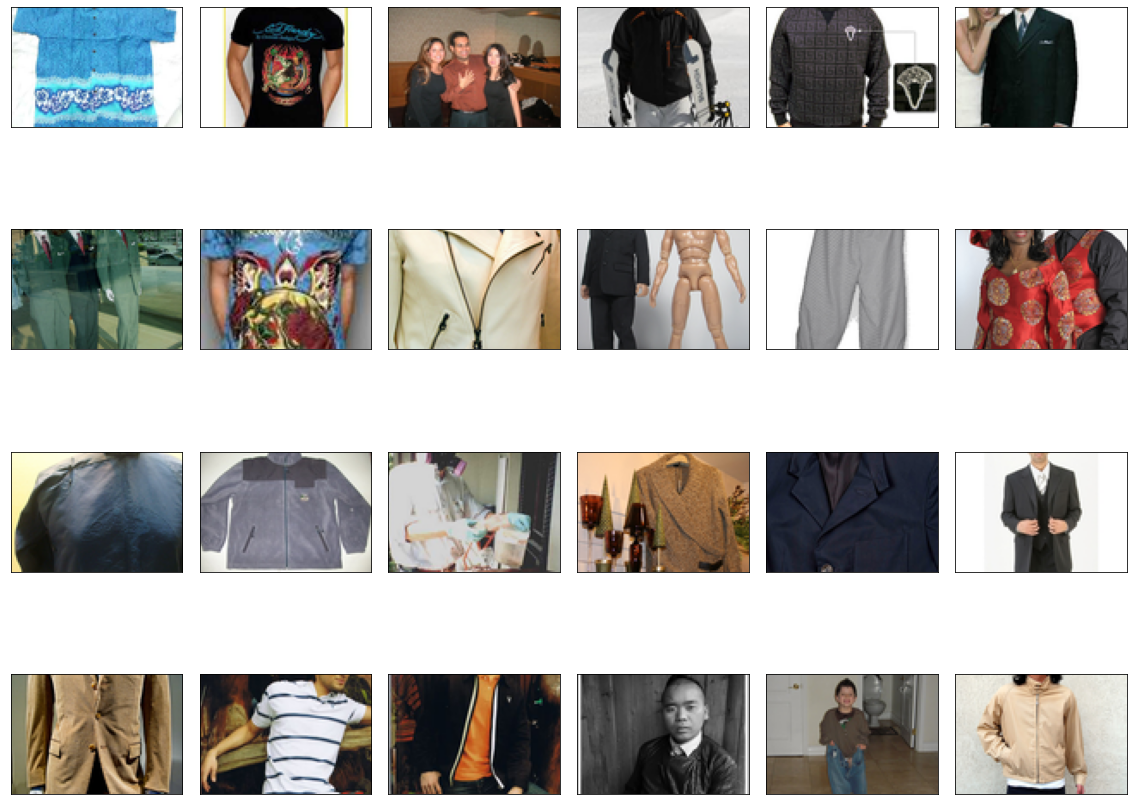

In [37]:
#plot the photos 
def original_photos(photos_resize):
    fig, ax = plt.subplots(4, 6, figsize=(20, 16),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

    k = 0
    for i in range(4):
        for j in range(6):
            ax[i, j].imshow(photos_resize[k])
            k += 1
            
    plt.show()
original_photos(man_resize)          

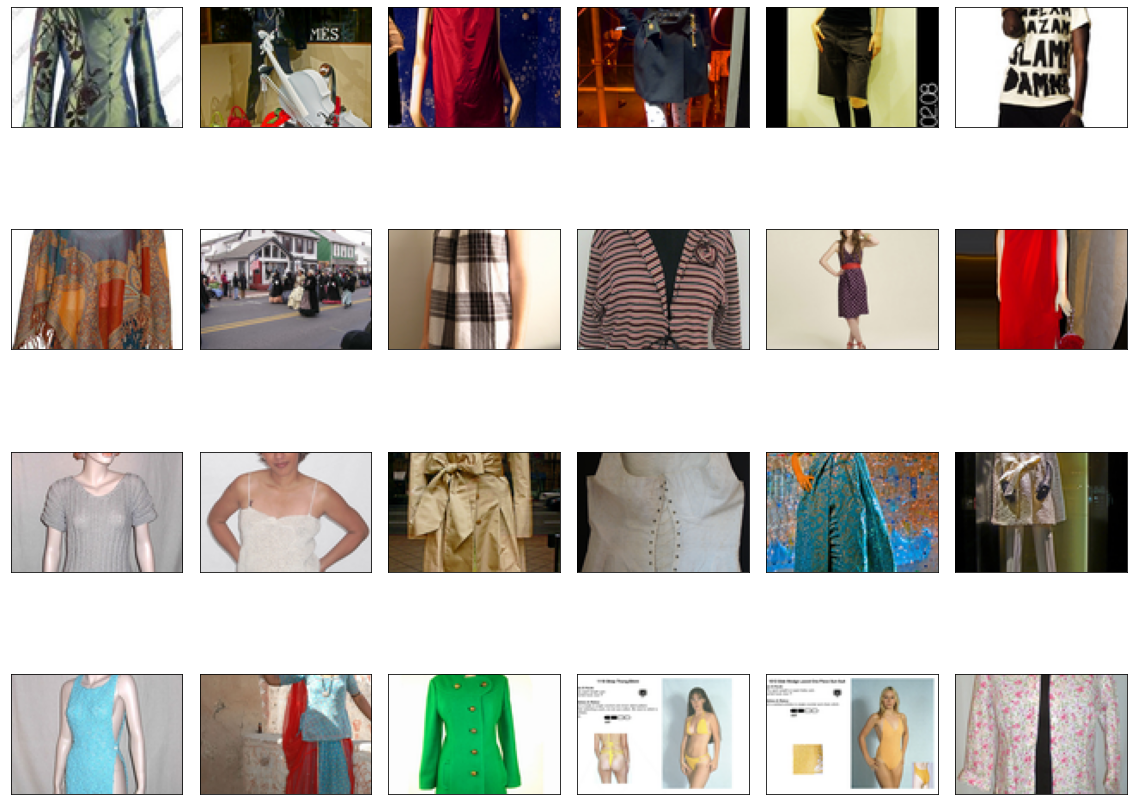

In [38]:
original_photos(woman_resize)          

In [39]:
#create the labels for man and woman 
Y_man = np.zeros(len(X_man))
Y_woman = np.ones(len(X_woman))

In [40]:
X_man.shape, Y_man.shape, X_woman.shape, Y_woman.shape

((1242, 21000), (1242,), (1270, 21000), (1270,))

In [41]:
#combine men and women data 
X = np.vstack((X_man, X_woman))
Y = np.vstack((Y_man.reshape(-1,1), Y_woman.reshape(-1,1)))

In [42]:
#train test split
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.20, random_state=123)

In [43]:
print(f'There are {len(X_train)} training images, and {len(X_test)} testing images.' )

There are 2009 training images, and 503 testing images.


# Model Training and Evaluation

## Linear SVC


In [108]:
lsvc = LinearSVC(verbose=0)
print(lsvc)

lsvc.fit(X_train, Y_train)
score = lsvc.score(X_train, Y_train)
print("Score: ", score)


LinearSVC()


/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score:  1.0


/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [109]:
#prediction
Y_train_pred = lsvc.predict(X_train)

train_score = classification_report(Y_train, Y_train_pred)
print(train_score)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1007
         1.0       1.00      1.00      1.00      1002

    accuracy                           1.00      2009
   macro avg       1.00      1.00      1.00      2009
weighted avg       1.00      1.00      1.00      2009



In [110]:
# cv_scores = cross_val_score(lsvc, X_train, Y_train, cv=5)
# print("CV average score: %.2f" % cv_scores.mean())

In [111]:
#prediction
Y_pred = lsvc.predict(X_test)

cr = classification_report(Y_test, Y_pred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.56      0.55      0.55       235
         1.0       0.61      0.62      0.62       268

    accuracy                           0.59       503
   macro avg       0.59      0.59      0.59       503
weighted avg       0.59      0.59      0.59       503



From comparing the training and testing dataset, we can see that the model is subjected to overfitting. However, since cross validation takes a long time to run for SVM, I decide to leave the model like this for now.  

Lastly, since the number of man photos is roughly the same as woman photos, we don't need to be concerned that unbalanced data can bias the prediciton. 

## PCA

Text(0.5, 1.0, 'PCA cumulative explained variance')

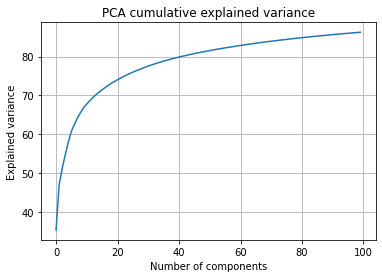

In [76]:
from sklearn.decomposition import PCA
# Use 100 components to see explained variance 
pca_100 = PCA(n_components=100)
pca_100.fit(X)

plt.grid()
plt.plot(np.cumsum(pca_100.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('PCA cumulative explained variance')

In [77]:
#Explained variance ratio with numbers of components

import pandas as pd
explained_var = np.cumsum(pca_100.explained_variance_ratio_ * 100).reshape(-1, 1)
num_comps = [i+1 for i in range(100)]
explained_var
explained_var_df = pd.DataFrame(explained_var,index=num_comps, columns = ['Explained Variance Ratio'])
explained_var_df

,Explained Variance Ratio
1,35.388350
2,47.035996
3,51.221437
4,54.750464
5,58.007420
...,...
96,86.020881
97,86.088510
98,86.154192
99,86.219163


In [94]:
#Find explained variance > 80% 
explained_var_df[explained_var_df.values >80] 

,Explained Variance Ratio
42,80.079055
43,80.262435
44,80.442641
45,80.618917
46,80.793078
47,80.953289
48,81.110406
49,81.262802
50,81.414462
51,81.564455


42 components can explain > 80% of the variance, we choose 42 components. 

In [95]:
def PCA_components(X, n): 
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(X)
    return principalComponents, pca

principalComponents_42, pca_42 = PCA_components(X, 42)

## Image reconstruction through PCA

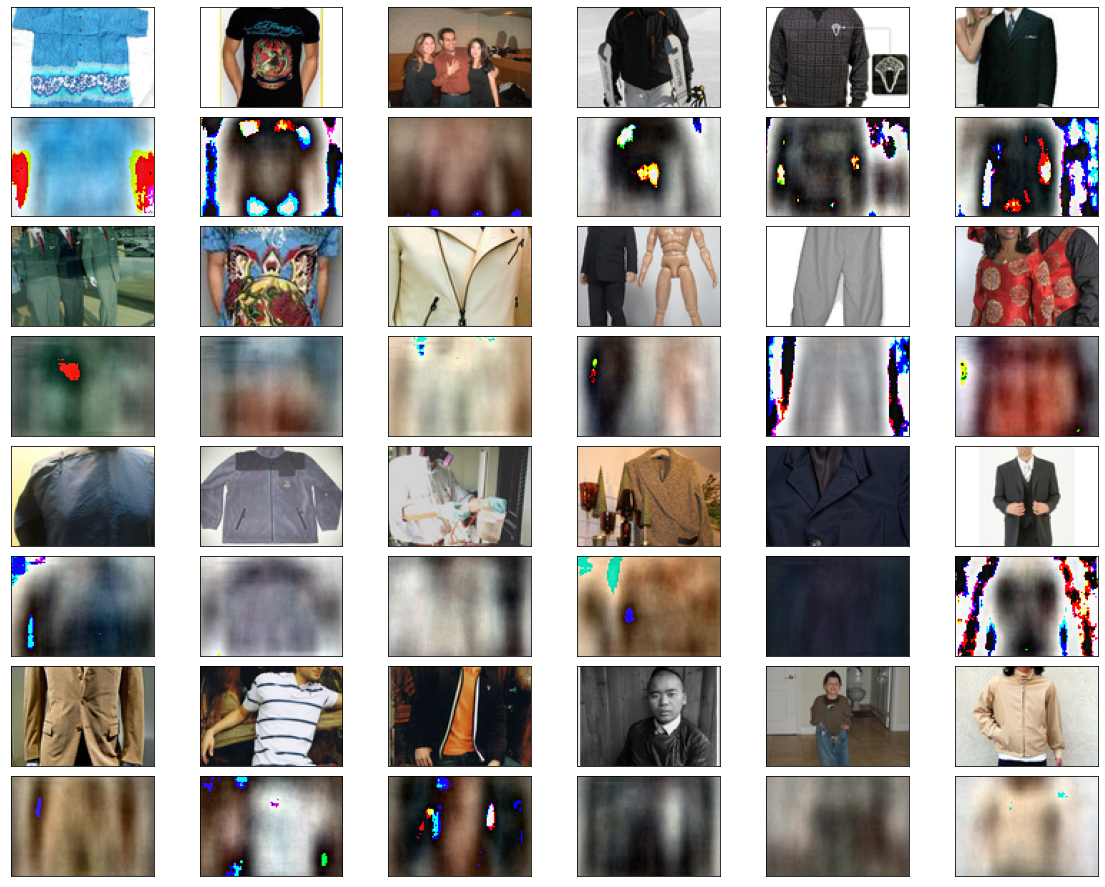

In [96]:
def reconstruction(principalComponents, pca, X, num_pics = 2512, new_width = 100, new_height = 70):
    X_inv = pca.inverse_transform(principalComponents)

    X_inv = np.reshape(X_inv,(num_pics,new_height, new_width, 3))

    #create the photos
    fig, ax = plt.subplots(8, 6, figsize=(20, 16),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
    k = 0
    for i in range(0,8,2):
        for j in range(6):
            image_proj = X_inv[k,:]
            ax[i, j].imshow(X[k])
            ax[i+1, j].imshow((image_proj).astype(np.uint8))
            k += 1
    plt.show()

reconstruction(principalComponents_42, pca_42, man_resize)

In [113]:
#train test split
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(principalComponents_42, Y, test_size=0.20, random_state=123)

#pca model
pca_lsvc = LinearSVC(verbose=0).fit(X_train_pca, Y_train_pca)

score = pca_lsvc.score(X_train_pca, Y_train_pca)
print("Score: ", score)

Score:  0.5858636137381782


/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [114]:
#prediction
Y_train_pred_pca = pca_lsvc.predict(X_train_pca)

pca_train_score = classification_report(Y_train_pca, Y_train_pred_pca)
print(pca_train_score)

              precision    recall  f1-score   support

         0.0       0.58      0.61      0.59      1007
         1.0       0.59      0.57      0.58      1002

    accuracy                           0.59      2009
   macro avg       0.59      0.59      0.59      2009
weighted avg       0.59      0.59      0.59      2009



In [115]:
#prediction
Y_pred_pca = pca_lsvc.predict(X_test_pca)

cr = classification_report(Y_test_pca, Y_pred_pca)
print(cr)

              precision    recall  f1-score   support

         0.0       0.53      0.58      0.56       235
         1.0       0.60      0.55      0.58       268

    accuracy                           0.57       503
   macro avg       0.57      0.57      0.57       503
weighted avg       0.57      0.57      0.57       503



Here, we can see the model for training and testing dataset has similar performance, 59% and 57% of accuracy respectively.  

## LDA 

In [116]:
lda = LDA()
lda_components = lda.fit_transform(X, Y)

lda.explained_variance_ratio_


/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1.])

For LDA, we only have one component left. In addition, since we will lose information during LDA process, we cannot execute inverse transform to reconstruct the photos. 

In [119]:
#train test split
X_train_lda, X_test_lda, Y_train_lda, Y_test_lda = train_test_split(lda_components, Y, test_size=0.20, random_state=123)

#pca model
lda_lsvc = LinearSVC(verbose=0).fit(X_train_lda, Y_train_lda)

score = lda_lsvc.score(X_train_lda, Y_train_lda)
print("Score: ", score)


Score:  0.9641612742658039


/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [120]:
#prediction
Y_train_pred_lda = lda_lsvc.predict(X_train_lda)

lda_train_score = classification_report(Y_train_lda, Y_train_pred_lda)
print(lda_train_score)


              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      1007
         1.0       0.96      0.96      0.96      1002

    accuracy                           0.96      2009
   macro avg       0.96      0.96      0.96      2009
weighted avg       0.96      0.96      0.96      2009



In [122]:
#prediction
Y_pred_lda = lda_lsvc.predict(X_test_lda)

cr = classification_report(Y_test_lda, Y_pred_lda)
print(cr)

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       235
         1.0       0.97      0.95      0.96       268

    accuracy                           0.96       503
   macro avg       0.96      0.96      0.96       503
weighted avg       0.96      0.96      0.96       503



We can see that LDA provides is a really good model that has 96% accuracy for both training and testing data. 

In [130]:
qda_model=QDA()
qda_model.fit(X_train,Y_train)

/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/swimmingcircle/Library/Python/3.9/lib/python/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [133]:
#qda model
y_train_pred=qda_model.predict(X_train)

qda_train_score = classification_report(Y_train, y_train_pred)
print(qda_train_score)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1007
         1.0       1.00      1.00      1.00      1002

    accuracy                           1.00      2009
   macro avg       1.00      1.00      1.00      2009
weighted avg       1.00      1.00      1.00      2009



In [134]:
#qda model
y_pred=qda_model.predict(X_test)

qda_test_score = classification_report(Y_test, y_pred)
print(qda_test_score)

              precision    recall  f1-score   support

         0.0       0.47      0.80      0.59       235
         1.0       0.54      0.21      0.31       268

    accuracy                           0.49       503
   macro avg       0.51      0.50      0.45       503
weighted avg       0.51      0.49      0.44       503



In [ ]:
y_pred=qda_model.predict(X_test)

pca_train_score = classification_report(Y_train_pca, Y_train_pred_pca)
print(pca_train_score)

## Summary 

The procedure of analysis
1. Data processing
2. Transform the dataset(LDA, PCA)or not 
3. Split into training and testing dataset 
4. Use training dataset to train a linear SVM
5. Create classification report on training and testing dataset prediction

## Result 


1. The original dataset 
- Training accuracy: 1
- Testing accuracy: 0.59

2. The PCA dataset (42 dimensions)
- Training accuracy: 0.59
- Testing accuracy: 0.57

3. The LDA dataset (1 dimension)
- Training accuracy: 0.96
- Testing accuracy: 0.96

4. The QDA model
- Training accuracy: 1
- Testing accuracy: 0.49


From the accuracy result, I will recommend LDA model. 
We won't use the original data for training due to overfitting and low prediction accuracy.
PCA focuses on capturing the direction of maximum variation in the data set. LDA focuses on finding a feature subspace that maximizes the separability between the groups.
Therefore, it is expected that LDA will have better performance than PCA. LDA works well with linear SVM might also because only one components exists which is easier to for linear SVM to classify the data. 

As for QDA, the sklearn doesn't have `fit_transform` function so I cannot create new compoenents based on QDA. Instead, I use the QDA model directly as a prediction model. From the result, we can see that overfitting exist in the QDA model as well. 

Comparing all the model and its performance, we will recommend using LDA for dimension reduction and use linear SVM to classify man and woman photos.  